## Build and display cme open interest history from ftp.cmegroup.com daily xlsx files

(This workbook executes several Bash commands, so the workbook will not work using Windows)

In [2]:
import pandas as pd
import numpy as np
import pypg.pg_pandas as pg
import os,sys
import openpyxl as pyxl
import re
from openpyxl import load_workbook
ftp_folder = 'ftp://ftp.cmegroup.com/daily_volume'
local_folder = 'cme_daily_volume'

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


___
### Set year to fetch from ftp site using wget
___

In [3]:
# !wget -P {local_folder}  {ftp_folder}/{file_name}
year = '2019'

csv_fn = 'cme_open_interest_%s' %(str(year))
# fetch the data if the below is True
if not os.path.isfile(csv_fn):
    !wget -r -l1 --no-parent  -P {local_folder} -A "daily_volume_{year}*.xlsx" ftp://ftp.cmegroup.com/daily_volume/
    !mv {local_folder}/ftp.cmegroup.com/daily_volume/*.xlsx {local_folder}

--2019-02-21 14:33:39--  ftp://ftp.cmegroup.com/daily_volume/
           => 'cme_daily_volume/ftp.cmegroup.com/daily_volume/.listing'
Resolving ftp.cmegroup.com... 52.7.201.185
Connecting to ftp.cmegroup.com|52.7.201.185|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /daily_volume ... done.
==> PASV ... done.    ==> LIST ... done.

ftp.cmegroup.com/da     [   <=>                ] 106.48K   192KB/s   in 0.6s   

2019-02-21 14:33:40 (192 KB/s) - 'cme_daily_volume/ftp.cmegroup.com/daily_volume/.listing' saved [109038]

Removed 'cme_daily_volume/ftp.cmegroup.com/daily_volume/.listing'.
Rejecting 'daily_volume.xlsx'.
Rejecting 'daily_volume_20140102.xlsx'.
Rejecting 'daily_volume_20140103.xlsx'.
Rejecting 'daily_volume_20140106.xlsx'.
Rejecting 'daily_volume_20140107.xlsx'.
Rejecting 'daily_volume_20140108.xlsx'.
Rejecting 'daily_volume_20140109.xlsx'.
Rejecting 'daily_volume_20140110.xlsx'.
Rejecting 'daily

==> PASV ... done.    ==> RETR daily_volume_20190102.xlsx ... done.
Length: 65342 (64K)

ftp.cmegroup.com/da 100%[=====================>]  63.81K  --.-KB/s   in 0.1s   

2019-02-21 14:33:40 (473 KB/s) - 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190102.xlsx' saved [65342]

--2019-02-21 14:33:40--  ftp://ftp.cmegroup.com/daily_volume/daily_volume_20190103.xlsx
           => 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190103.xlsx'
==> CWD not required.
==> PASV ... done.    ==> RETR daily_volume_20190103.xlsx ... done.
Length: 67756 (66K)

ftp.cmegroup.com/da 100%[=====================>]  66.17K  --.-KB/s   in 0.1s   

2019-02-21 14:33:40 (581 KB/s) - 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190103.xlsx' saved [67756]

--2019-02-21 14:33:40--  ftp://ftp.cmegroup.com/daily_volume/daily_volume_20190104.xlsx
           => 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190104.xlsx'
==> CWD not required.
==> PASV ...

==> PASV ... done.    ==> RETR daily_volume_20190128.xlsx ... done.
Length: 68105 (67K)

ftp.cmegroup.com/da 100%[=====================>]  66.51K  --.-KB/s   in 0.1s   

2019-02-21 14:33:44 (501 KB/s) - 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190128.xlsx' saved [68105]

--2019-02-21 14:33:44--  ftp://ftp.cmegroup.com/daily_volume/daily_volume_20190129.xlsx
           => 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190129.xlsx'
==> CWD not required.
==> PASV ... done.    ==> RETR daily_volume_20190129.xlsx ... done.
Length: 68484 (67K)

ftp.cmegroup.com/da 100%[=====================>]  66.88K  --.-KB/s   in 0.1s   

2019-02-21 14:33:44 (477 KB/s) - 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190129.xlsx' saved [68484]

--2019-02-21 14:33:44--  ftp://ftp.cmegroup.com/daily_volume/daily_volume_20190130.xlsx
           => 'cme_daily_volume/ftp.cmegroup.com/daily_volume/daily_volume_20190130.xlsx'
==> CWD not required.
==> PASV ...

___
### Extract the open interest data from the xlsx workbook

* This takes a long time, so don't rerun it if you have already created a DataFrame for the year
___

In [4]:
if not os.path.isfile(csv_fn):

    # get all of the xlsx files
    file_names = os.listdir(local_folder)

    # Create a place holder for the final DataFrame
    df_all_col_data = None

    # valid files have 'daily_volume' in the name, 
    for fn in file_names:
        if 'daily_volume' not in fn:
            continue
        # and valid files have the year that we are currently working on in the name as well
        if year not in fn:
            continue

        # If you get here, you will process the xlsx or xls file
        full_path = f'{local_folder}/{fn}'
        if len(re.findall('.xls$',full_path)) > 0:
            # if the file is an xls file, convert it to xlsx using libreoffice
            !/Applications/LibreOffice.app/Contents/MacOS/soffice --convert-to xlsx {full_path} --headless --outdir {local_folder} 
            full_path = full_path + "x"

        print(f'processing {full_path} ')

        # Get a workbook
        wb = load_workbook(filename = full_path)
        # Get a worksheet
        sheet_ranges = wb['CME Group Vol and OI by Product']
        # find Header column by finding Description
        first_row = None
        for i in range(1,20):
            cell_val = sheet_ranges[f'A{str(i)}'].value
            if 'description' in str(cell_val).lower():
                first_row = str(i)
                break
        if first_row is None:
            print('ERROR: cannot find header column')
            break

        # Get the column names, and get rid of non-alphabetic characters
        data = sheet_ranges[f'A{first_row}:L1000']
        cols = ['_'.join(re.findall('[A-Za-z ]{1,}',str(data[0][i].value))) for i in range(12)]
        cols = [c.strip().replace(' ','_').replace('__','_') for c in cols]

        # Populate col_data, which has all of the data for each column
        col_data = []
        for j in range(12):
            this_col = []
            for i in range(1,len(data)):
                this_col.append(data[i][j].value)
            col_data.append(this_col)

        # Create the dictionary of column names and data for creating the DataFrame
        dict_for_df = {cols[i]:col_data[i] for i in range(12)}

        # Create the DataFrame
        df_col_data = pd.DataFrame(dict_for_df) 

        # Add a trade_date field
        df_col_data['trade_date'] = int(re.findall('20[0-9]{2}[0-1][0-9][0-3][0-9]',fn)[0])

        # populate df_all_col_data, which is the dataframe that holds all of the open interest data for each day
        if df_all_col_data is None:
            df_all_col_data = df_col_data.copy()
        else:
            df_all_col_data = df_all_col_data.append(df_col_data)
            
    # Save df_all_col_data and save a version just for CL
    df_all_col_data.to_csv(f'./cme_open_interest_{year}.csv',index=False)
    df_all_col_data[df_all_col_data.Commodity_Indicator=='CL'].to_csv(f'./cl_open_interest_{year}.csv',index=False)
            

processing cme_daily_volume/daily_volume_20190102.xlsx 
processing cme_daily_volume/daily_volume_20190103.xlsx 
processing cme_daily_volume/daily_volume_20190104.xlsx 
processing cme_daily_volume/daily_volume_20190107.xlsx 
processing cme_daily_volume/daily_volume_20190108.xlsx 
processing cme_daily_volume/daily_volume_20190109.xlsx 
processing cme_daily_volume/daily_volume_20190110.xlsx 
processing cme_daily_volume/daily_volume_20190111.xlsx 
processing cme_daily_volume/daily_volume_20190114.xlsx 
processing cme_daily_volume/daily_volume_20190115.xlsx 
processing cme_daily_volume/daily_volume_20190116.xlsx 
processing cme_daily_volume/daily_volume_20190117.xlsx 
processing cme_daily_volume/daily_volume_20190118.xlsx 
processing cme_daily_volume/daily_volume_20190122.xlsx 
processing cme_daily_volume/daily_volume_20190123.xlsx 
processing cme_daily_volume/daily_volume_20190124.xlsx 
processing cme_daily_volume/daily_volume_20190125.xlsx 
processing cme_daily_volume/daily_volume_2019012

___
### Create the df_commodity_all_years DataFrame which has CL open interest data for multiple years
___

In [5]:
commodity = 'GC'
csv_name_template = './cme_open_interest_%s.csv'
df_commodity_all_years = None
years = [2013,2014,2015,2016,2017,2018,2019]
for y in years:
    n = csv_name_template %(str(y))
    df_temp = pd.read_csv(n)
    df_temp = df_temp[df_temp.Commodity_Indicator==commodity]
    if df_commodity_all_years is None:
        df_commodity_all_years = df_temp.copy()
    else:
        df_commodity_all_years = df_commodity_all_years.append(df_temp)

# make sure it's sorted
df_commodity_all_years_sorted = df_commodity_all_years.sort_values(by='trade_date')
df_commodity_all_years_sorted.index = range(len(df_commodity_all_years_sorted))

/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (3,6,7,8,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/bperlman1/Virtualenvs3/pyliverisk/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


___
### Create a method that Plots Commodity open interest, and selected ETF
___

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt
def plot_open_interest(df_in):
    df_cl = df_in[['trade_date','Open_Interest','etf']]
    df_cl = df_cl.drop_duplicates()
    xs = list(df_cl.trade_date)
    df_cl['trade_date'] = df_cl.trade_date.apply(lambda i:str(i))

    x = list(range(len(df_cl)))
    num_x_ticks = 20
    x_indices = np.linspace(0,len(x)//num_x_ticks*num_x_ticks,num_x_ticks+1)
    x_labels = [str(t) for t in list(df_cl.iloc[x_indices].trade_date)]
    y = list(df_cl.Open_Interest)
    y2 = list(df_cl['etf'])

    fig, ax = plt.subplots(1,1,figsize=(10,8))
    ax.grid(color='lightgray', alpha=0.7)

    ax.plot(x,y,'b-')
    ax.tick_params('y', colors='b')
    plt.xticks(x_indices, x_labels, rotation='vertical')
    plt.subplots_adjust(bottom=0.20)
    plt.xticks(rotation=60)

    ax2 = ax.twinx()
    ax2.plot(x,y2,'r-')
    ax2.tick_params('y', colors='r')

    plt.show()


### Execute the plot

In [13]:
etf_path = 'gld_daily.csv'
df_etf_daily = pd.read_csv(etf_path)
df_etf_daily = df_etf_daily.drop_duplicates()
df_etf_daily['trade_date'] = df_etf_daily.Date.apply(lambda s: int(s[0:4]+s[5:7]+s[8:10]))
df_etf_daily2 = df_etf_daily.sort_values(by='trade_date')
df_etf_daily3 = df_etf_daily2[['trade_date','Adj Close']].rename(columns={'Adj Close':'etf'})
df_commodity_all_years_with_etf = df_commodity_all_years_sorted.merge(df_etf_daily3,how='inner',on='trade_date')
df_commodity_all_years_with_etf.trade_date = df_commodity_all_years_with_etf.trade_date.astype(int)
df_commodity_all_years_with_etf = df_commodity_all_years_with_etf.drop_duplicates()

<IPython.core.display.Javascript object>


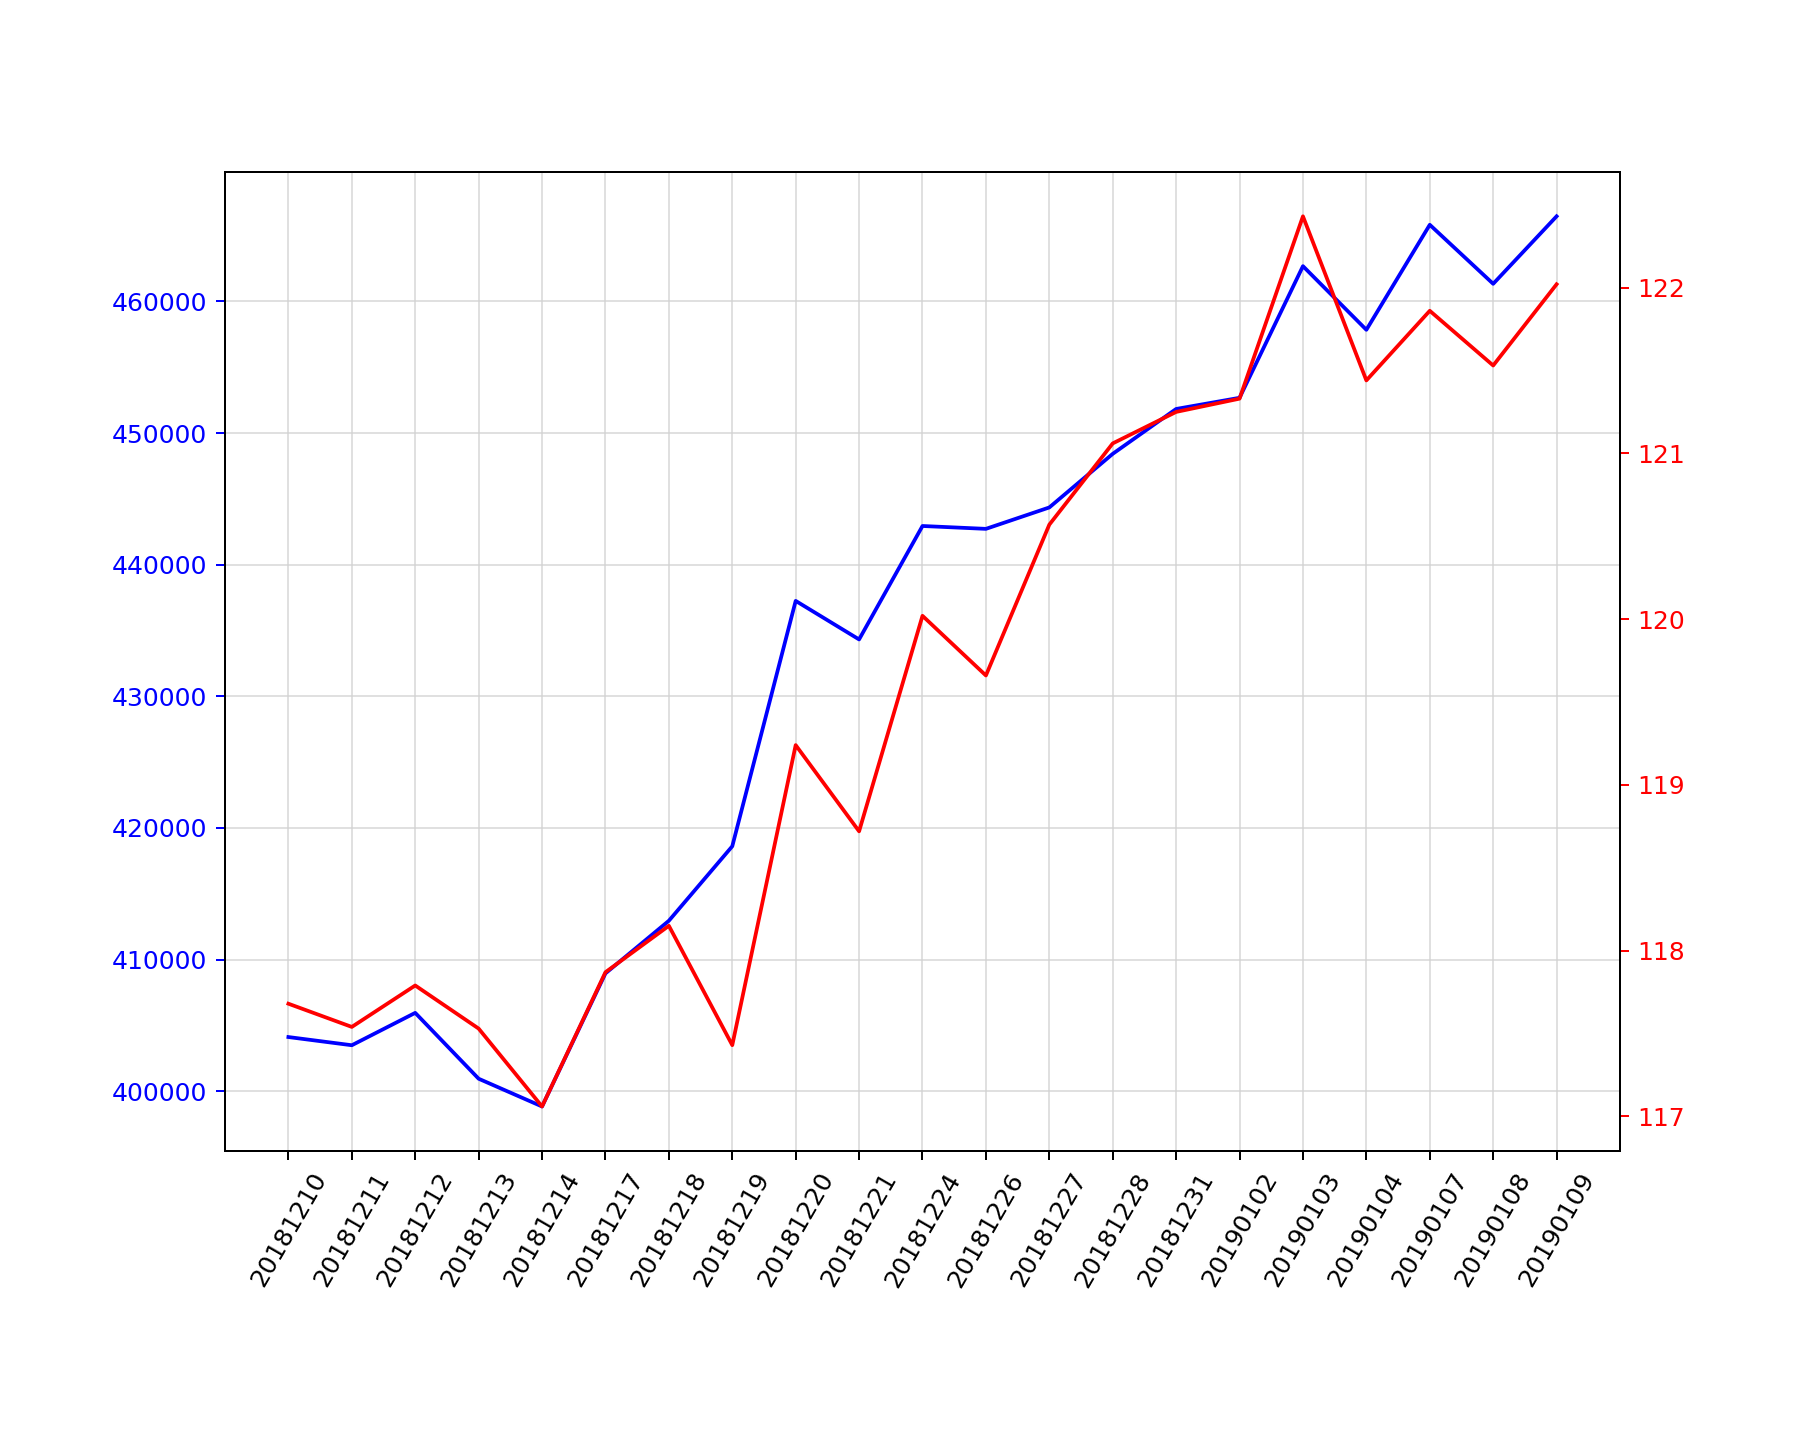

In [15]:
plot_open_interest(df_commodity_all_years_with_etf)

### Execute a zoomed in version

<IPython.core.display.Javascript object>


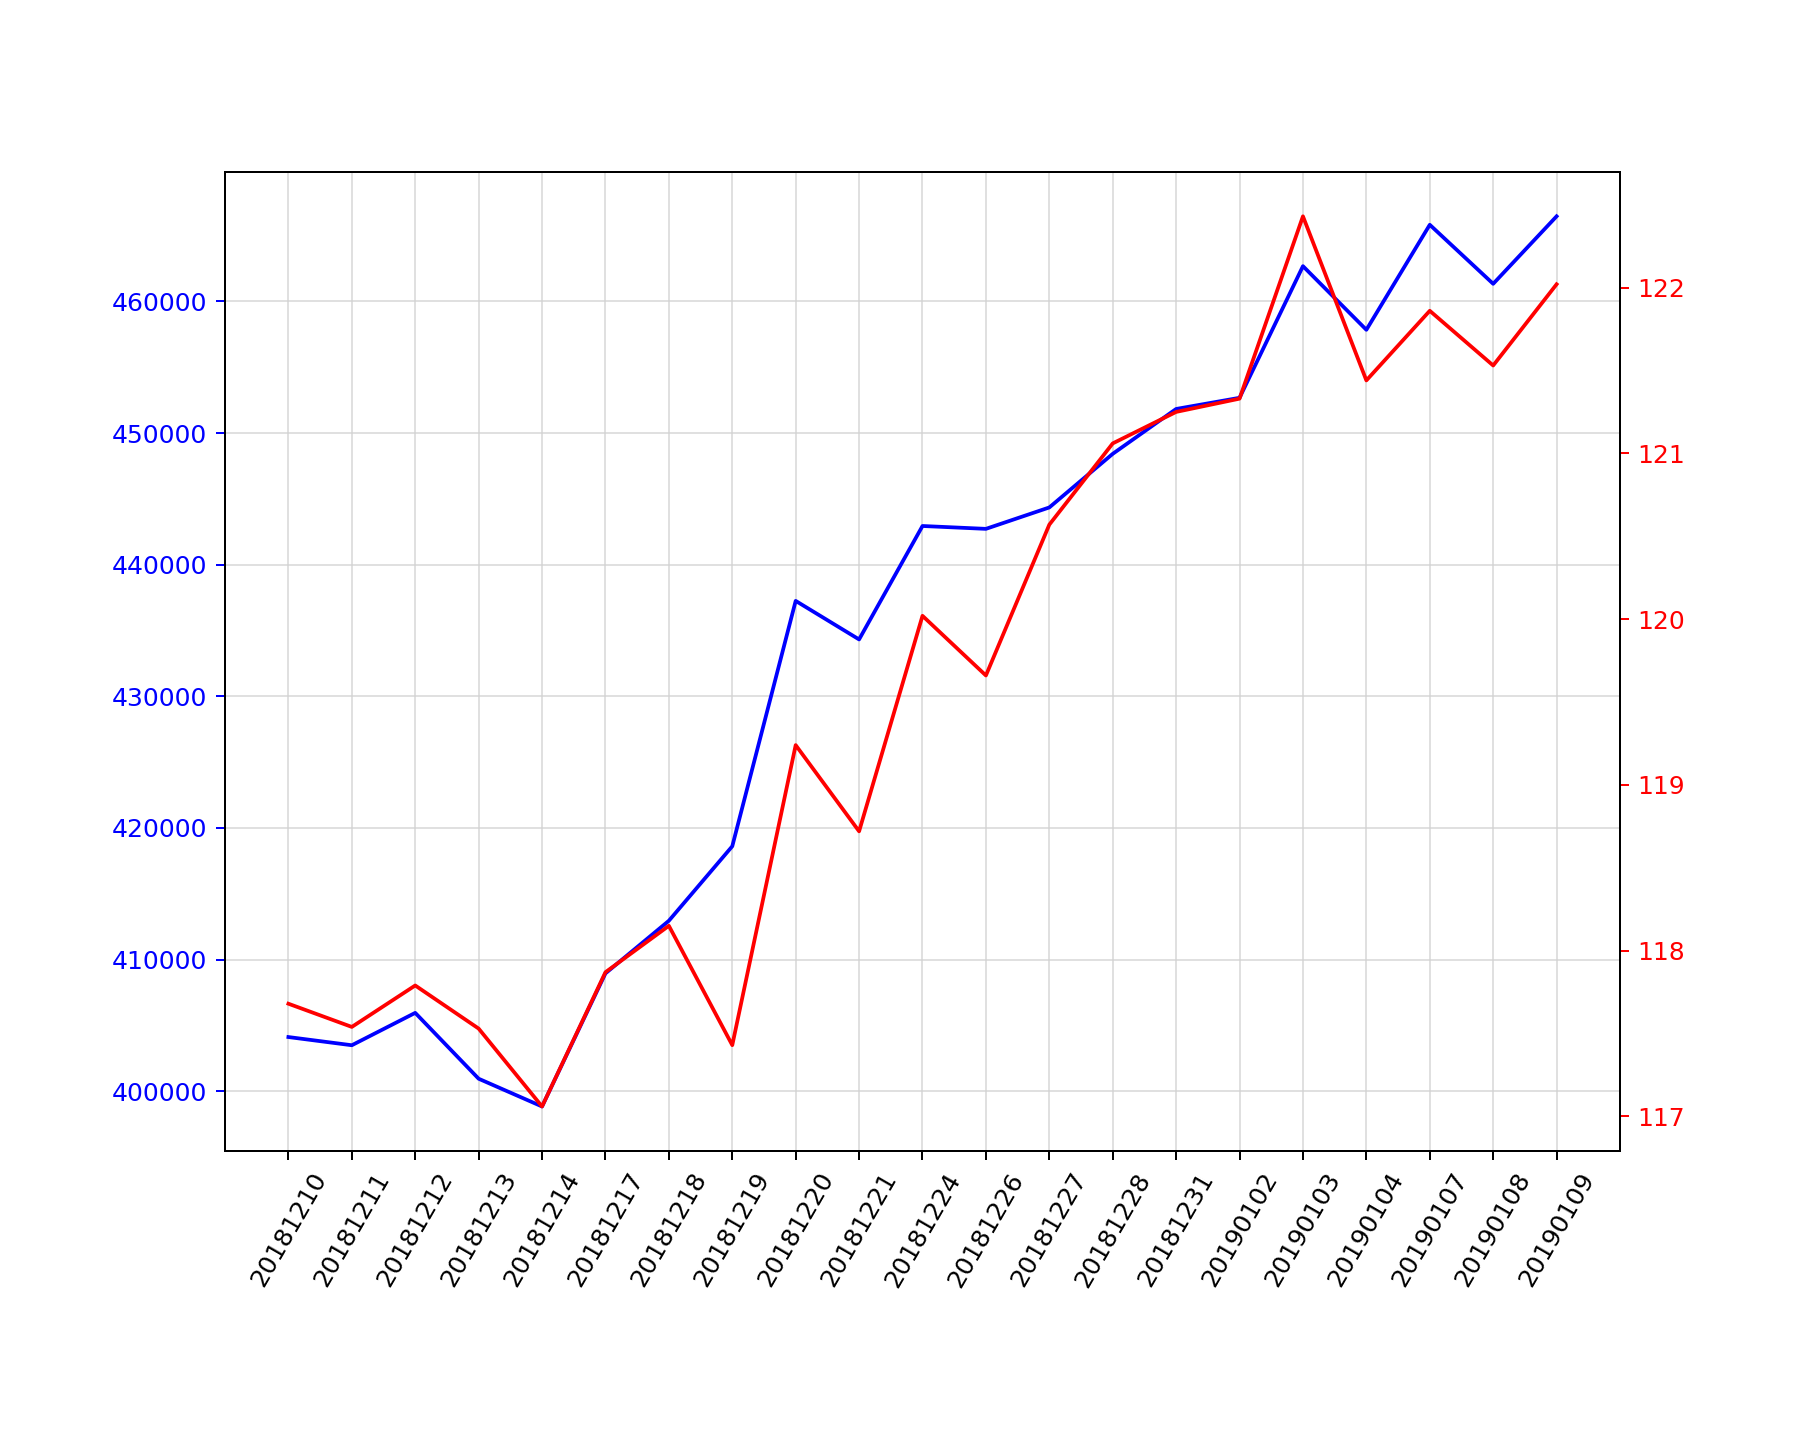

In [18]:
df_sub = df_commodity_all_years_with_etf[df_commodity_all_years_with_etf.trade_date>20181000][['trade_date','Open_Interest','etf']].drop_duplicates()
plot_open_interest(df_sub)

In [19]:
df_sub.tail(10)

,trade_date,Open_Interest,etf
11,20181226,442724,119.660004
12,20181227,444351,120.570000
13,20181228,448423,121.059998
14,20181231,451832,121.250000
15,20190102,452680,121.330002
17,20190103,462682,122.430000
19,20190104,457846,121.440002
20,20190107,465825,121.860001
21,20190108,461340,121.529999
22,20190109,466468,122.019997


In [21]:
commodity = 'GC'
df_commod = df_all_col_data[df_all_col_data.Commodity_Indicator==commodity]
df_commod

,CME__Globex__Volume,Commodity_Indicator,Description,ExPit_Volume,Exchange_Name,Future_Option_Indicator,MTD_ADV,OTC_Volume,Open_Interest,Pit_Volume,Product_Description,Total_Volume,trade_date
770,242703.0,GC,METALS,0.0,COMEX(STATS),F,254553.000000,11850.0,452680.0,0.0,GOLD FUTURES,254553.0,20190102
776,255834.0,GC,METALS,0.0,COMEX(STATS),F,261963.500000,13540.0,462682.0,0.0,GOLD FUTURES,269374.0,20190103
767,318304.0,GC,METALS,0.0,COMEX(STATS),F,286008.333333,15794.0,457846.0,0.0,GOLD FUTURES,334098.0,20190104
755,216220.0,GC,METALS,0.0,COMEX(STATS),F,270058.500000,5989.0,465825.0,0.0,GOLD FUTURES,222209.0,20190107
756,264252.0,GC,METALS,0.0,COMEX(STATS),F,270833.800000,9683.0,461340.0,0.0,GOLD FUTURES,273935.0,20190108
763,277091.0,GC,METALS,0.0,COMEX(STATS),F,273756.333333,11278.0,466468.0,0.0,GOLD FUTURES,288369.0,20190109
757,284973.0,GC,METALS,0.0,COMEX(STATS),F,276740.000000,9669.0,479136.0,0.0,GOLD FUTURES,294642.0,20190110
749,249188.0,GC,METALS,0.0,COMEX(STATS),F,274154.125000,6865.0,481516.0,0.0,GOLD FUTURES,256053.0,20190111
753,264150.0,GC,METALS,0.0,COMEX(STATS),F,274441.666667,12592.0,498906.0,0.0,GOLD FUTURES,276742.0,20190114
742,266813.0,GC,METALS,0.0,COMEX(STATS),F,274920.000000,12412.0,503096.0,0.0,GOLD FUTURES,279225.0,20190115


## End